In [1]:
from diffusers import StableDiffusionPipeline
import pathlib as pb
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
repo_path = pb.Path('..', 'repo')
model_path = repo_path / 'stable-diffusion-v1-5'
txt2img = StableDiffusionPipeline.from_pretrained(model_path,
                                                  revision='fp16',
                                                  torch_dtype=torch.float16)
txt2img = txt2img.to(device)
txt2img.enable_attention_slicing()

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [28]:
text_prompt = "guy breaking into somebody's house at daytime"

with torch.inference_mode():
  sample = txt2img(text_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

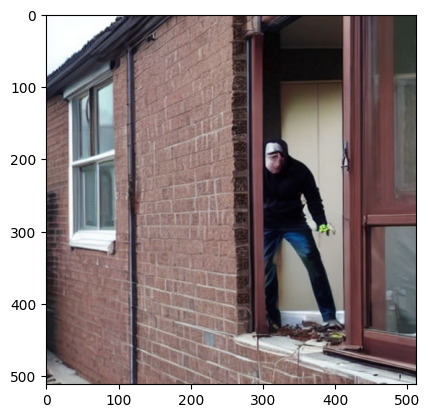

In [29]:
import matplotlib.pyplot as plt

plt.imshow(sample.images[0])

TypeError: Image data of dtype object cannot be converted to float

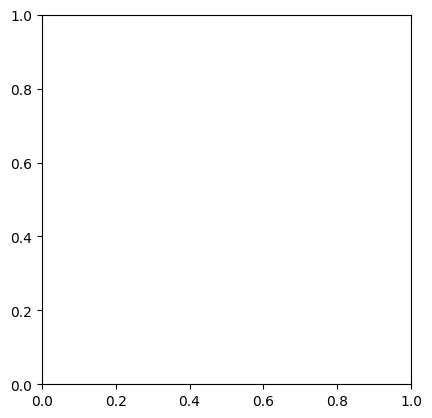

In [5]:
import matplotlib.pyplot as plt

plt.imshow(image)